In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from PIL import Image
import os
import json
import pickle
import numpy as np

class RefCocoG_Dataset(Dataset):
    full_annotations = None

    def __init__(self, root_dir, annotations_f, instances_f, split='train', transform=None, target_transform=None) -> None:
        super().__init__()

        self.root_dir = root_dir
        self.annotations_f = annotations_f
        self.instances_f = instances_f

        self.split = split

        self.transform = transform
        self.target_transform = target_transform

        self.get_annotations()
        self.image_names = list([
            self.annotations[id]['image']['actual_file_name']
            for id in self.annotations
        ])

    def get_annotations(self):
        if RefCocoG_Dataset.full_annotations:
            self.annotations = dict(filter(lambda match: match[1]['image']['split'] == self.split, RefCocoG_Dataset.full_annotations.items()))
            return

        # Load pickle data
        with open(os.path.join(self.root_dir, 'annotations', self.annotations_f), 'rb') as file:
            self.data = pickle.load(file)

        # Load instances
        with open(os.path.join(self.root_dir, 'annotations', self.instances_f), 'rb') as file:
            self.instances = json.load(file)

        # Match data between the two files and build the actual dataset
        self.annotations = {}

        images_actual_file_names = {}
        for image in self.instances['images']:
            images_actual_file_names[image['id']] = image['file_name']

        for image in self.data:
            if image['ann_id'] not in self.annotations:
                self.annotations[image['ann_id']] = {}

            self.annotations[image['ann_id']]['image'] = image
            self.annotations[image['ann_id']]['image']['actual_file_name'] = images_actual_file_names[image['image_id']]

        for annotation in self.instances['annotations']:
            if annotation['id'] not in self.annotations:
                continue

            self.annotations[annotation['id']]['annotation'] = annotation

        # Keep only samples from the given split
        RefCocoG_Dataset.full_annotations = self.annotations
        self.annotations = dict(filter(lambda match: match[1]['image']['split'] == self.split, self.annotations.items()))

    def __len__(self):
        # Return the number of images
        return len(self.image_names)

    def corner_size_to_corners(self, bounding_box):
        """
        Transform (top_left_x, top_left_y, width, height) bounding box representation
        into (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
        """

        return [
            bounding_box[0],
            bounding_box[1],
            bounding_box[0] + bounding_box[2],
            bounding_box[1] + bounding_box[3]
        ]

    def __getitem__(self, idx):
        # Get the image name at the given index
        image_name = self.image_names[idx]

        # Load the image file as a PIL image
        image = Image.open(os.path.join(self.root_dir, 'images', image_name)).convert('RGB')
        # image = read_image(os.path.join(self.root_dir, 'images', image_name), ImageReadMode.RGB)
        
        image_id = list(self.annotations)[idx]

        # print(image_id)

        # Get the caption for the image
        prompts = [
            prompt['sent'] for prompt in self.annotations[image_id]['image']['sentences']
        ]

        # Get the bounding box for the prompts for the image
        bounding_box = self.corner_size_to_corners(self.annotations[image_id]['annotation']['bbox'])

        # Apply the transform if given
        if self.transform:
            image = self.transform(image)

        sample = [
            image,
            bounding_box,
            prompts,
        ]

        # Return the sample as a list
        return sample

In [3]:
dataset_train = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='train')
dataset_val = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='val')
dataset_test = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='test')

dataset_splits = [
    dataset_train,
    dataset_val,
    dataset_test
]

In [4]:
len(RefCocoG_Dataset.full_annotations), len(dataset_train.annotations), len(dataset_val.annotations), len(dataset_test.annotations)

(49820, 42224, 2573, 5023)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from PIL import Image
import os
import json
import pickle
import numpy as np
import pandas as pd

class RefCocoG_Dataset_Preprocessed(Dataset):

    def __init__(self, root_dir, split='train') -> None:
        super().__init__()

        self.root_dir = root_dir

        self.split = split

        self.data = pd.read_csv(os.path.join(self.root_dir, f'{self.split}_data.csv'))

    def __len__(self):
        # Return the number of images
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, :-4]), torch.tensor(self.data.iloc[idx, -4:])

In [6]:
dataset_preprocessed_train = RefCocoG_Dataset_Preprocessed('preprocessed', split='train')
dataset_preprocessed_test = RefCocoG_Dataset_Preprocessed('preprocessed', split='test')

dataset_splits = [
    dataset_preprocessed_train,
    dataset_preprocessed_test,
    dataset_preprocessed_test
]

In [7]:
def collate_differently_sized_prompts(batch):
    images = [item[0] for item in batch]
    bboxes = [item[1] for item in batch]
    prompts = [item[2] for item in batch]
    
    return list(images), list(bboxes), list(prompts)

def get_data(dataset_splits, batch_size=64, test_batch_size=256, num_workers=0, collate_fn=None):
    training_data = dataset_splits[0]
    validation_data = dataset_splits[1]
    test_data = dataset_splits[2]

    # Change shuffle to True for train
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = get_data(dataset_splits, batch_size=512, test_batch_size=512, num_workers=0)#, collate_fn=collate_differently_sized_prompts)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") # First GPU
else:
    device = 'cpu'

In [10]:
# if torch.cuda.is_available():
#     yolo_models = [torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(f'cuda:{i}') for i in range(torch.cuda.device_count())]
# else:
#     yolo_models = [torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)]

In [11]:
import clip

models, preprocesses = [], []

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        model, preprocess = clip.load("ViT-B/32", device=f'cuda:{i}')
        
        models.append(model)
        preprocesses.append(preprocess)
else:
    model, preprocess = clip.load("ViT-B/32", device=device)
    models.append(model)
    preprocesses.append(preprocess)

In [12]:
next(models[0].parameters()).device

device(type='cuda', index=0)

In [13]:
import torch

def cosine_similarity(a: torch.Tensor, b: torch.Tensor):
    """
    Cosine Similarity

    Normalizes both tensors a and b. Returns <b, a.T> (inner product).
    """

    a_norm = a / a.norm(dim=-1, keepdim=True)
    b_norm = b / b.norm(dim=-1, keepdim=True)

    similarity = (b_norm @ a_norm.T)

    return similarity.cpu()

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualise_scores(scores: torch.Tensor, images, texts: list[str]):
    for t_idx, text in enumerate(texts):
        for i_idx, image in enumerate(images):
            fig, ax = plt.subplots()
            ax.imshow(image)
            ax.set_title(f'Score: {scores[t_idx, i_idx]} / Prompt: {text}')

In [15]:
# model, preprocess = clip.load("ViT-B/32")

In [16]:
import torch
import torch.nn as nn
import clip
import numpy as np
import torch.nn.functional as F

# class RegressorModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.clip_out_features = 512

#         self.fc1 = nn.Linear(2 * self.clip_out_features, 4 * self.clip_out_features, bias=False).double()
#         self.fc2 = nn.Linear(4 * self.clip_out_features, 8 * self.clip_out_features, bias=False).double()
#         self.fc3 = nn.Linear(8 * self.clip_out_features, 2 * self.clip_out_features, bias=False).double()
#         self.fc4 = nn.Linear(2 * self.clip_out_features, 4, bias=False).double()

#     def forward(self, x):
#         """
#         x is a tensor of features representing CLIP's image features and
#         CLIP's text features concatenated into a tensor with length 1024 (512 + 512)
#         """

#         x = self.fc1(x)
#         x = F.relu(x)

#         x = self.fc2(x)
#         x = F.relu(x)

#         x = self.fc3(x)
#         x = F.relu(x)

#         x = self.fc4(x)

#         return x


class RegressorModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.clip_out_features = 512

        self.fc1 = nn.Linear(2 * self.clip_out_features, self.clip_out_features).double()
        self.fc2 = nn.Linear(self.clip_out_features, self.clip_out_features // 2).double()
        self.fc3 = nn.Linear(self.clip_out_features // 2, 128).double()
        self.fc4 = nn.Linear(128, 4).double()

    def forward(self, x):
        """
        x is a tensor of features representing CLIP's image features and
        CLIP's text features concatenated into a tensor with length 1024 (512 + 512)
        """

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)

        return x


class MultiNetModel(nn.Module):
    def __init__(self, models, preprocesses):# model=None, preprocess=None):
        super().__init__()

        # if model is None or preprocess is None:
        #     self.model, self.preprocess = clip.load("ViT-B/32")
        # else:
        #     self.model, self.preprocess = model, preprocess
        self.models = models
        self.preprocesses = preprocesses

        self.clip_out_features = 512

        # self.regressor = nn.Sequential(
        #     nn.Linear(2 * self.clip_out_features, 4 * self.clip_out_features),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(4 * self.clip_out_features, 6 * self.clip_out_features),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(6 * self.clip_out_features, 4),
        # ).to(device)
        self.regressor = RegressorModel().half().to(device)

    def forward(self, indices: torch.Tensor, images: torch.Tensor, prompts) -> torch.Tensor:
        self.device = indices.device
        if indices.is_cuda:
            self.device_index = int(str(self.device)[-1])
        else:
            self.device_index = 0

        model, preprocess = self.models[self.device_index], self.preprocesses[self.device_index]

        images = [images[i] for i in indices]
        prompts = [prompts[i] for i in indices]

        preprocessed_images = torch.stack([
            preprocess(image) for image in images
        ]).to(self.device)
        preprocessed_prompts = torch.cat([
            tokenized for tokenized in
            [clip.tokenize(prompt_list) for prompt_list in prompts]
        ]).to(self.device)

        # Storing the index for each prompt so as to easily retreive its encoding
        prompts_indices_for_image = []
        start_index = 0
        for prompt_list in prompts:
            prompts_indices_for_image.append(
                torch.tensor(list(range(0, len(prompt_list)))).to(self.device) + start_index
            )
            start_index += len(prompt_list)

        # tot = 0
        # for prompt_list in prompts:
        #     tot += len(prompt_list)
        # # print(f'there are {tot} prompts, {preprocessed_prompts.shape}')
        # # print(f'{prompts_indices_for_image[-1][-1] + 1} prompts on {prompts_indices_for_image[-1].device}. Given {tot} prompts')
        # return None

        with torch.no_grad():
            images_features = model.encode_image(preprocessed_images)
            # print(f'{images_features.shape}, {images_features.device}')
            texts_features = model.encode_text(preprocessed_prompts)
            # print(f'{texts_features.shape}, {texts_features.device}')

            # texts_features = []
            # for idx, preprocessed_prompts_for_sample in enumerate(preprocessed_prompts):
            #     text_features = model.encode_text(preprocessed_prompts_for_sample)
            #     texts_features.append(text_features)

        text_features_by_image = [
            texts_features[indices]
            for indices in prompts_indices_for_image
        ]

        bboxes = []
        for image_features, text_features_for_image in zip(images_features, text_features_by_image):
            # print(f'shapes: {image_features.shape}, {text_features_for_image.shape}')
            for text_features in text_features_for_image:
                x = torch.cat([image_features, text_features], dim=0).to(torch.float16)
                bbox = self.regressor(x)
                bboxes.append(bbox)

        # Compute the cosine similarity between an image and its prompts
        # similarities = []
        # for idx, text_features_for_image in enumerate(text_features_by_image):
        #     similarities.append(cosine_similarity(images_features[idx], text_features_for_image))

        

        # print(f'{images.device}, {images.shape}, {len(prompts)}')
        # print(f'images: {images}, prompts: {prompts}')
        # print(next(self.models[self.device_index].parameters()).device)
        
        # return images_features, texts_features
        return torch.stack(bboxes)

multinet_model = MultiNetModel(models, preprocesses)#model=model, preprocess=preprocess)

if torch.cuda.device_count() > 1:
    multinet_model = torch.nn.DataParallel(multinet_model)

In [17]:
import torch
import torch.nn as nn
import clip
import numpy as np
import torch.nn.functional as F

class BoundingBoxModel(nn.Module):
    def __init__(self, models, preprocess):
        super().__init__()
        
        self.models = models
        self.preprocesses = preprocesses

        self.fc1 = nn.Linear(1024, 4096)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4096, 512 * 6)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(6 * 512, 4)

    def forward(self, indices: torch.Tensor, images: torch.Tensor, prompts) -> torch.Tensor:
        self.device = indices.device
        if indices.is_cuda:
            self.device_index = int(str(self.device)[-1])
        else:
            self.device_index = 0

        model, preprocess = self.models[self.device_index], self.preprocesses[self.device_index]

        images = [images[i] for i in indices]
        prompts = [prompts[i] for i in indices]

        preprocessed_images = torch.stack([
            preprocess(image) for image in images
        ]).to(self.device)
        preprocessed_prompts = torch.cat([
            clip.tokenize(prompt) for prompt in prompts
        ]).to(self.device)

        with torch.no_grad():
            images_features = model.encode_image(preprocessed_images).float()
            texts_features = model.encode_text(preprocessed_prompts).float()

        # print(f'{images_features.shape}, {texts_features.shape}')

        features = torch.cat([images_features, texts_features], dim=1)
        x = self.fc1(features)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

boundingbox_model = BoundingBoxModel(models, preprocesses).to(device)

if torch.cuda.device_count() > 1:
    boundingbox_model = torch.nn.DataParallel(boundingbox_model)

In [18]:
next(boundingbox_model.module.models[1].parameters()).device

device(type='cuda', index=1)

In [19]:
from torchvision.ops import box_iou

def iou_metric(bounding_boxes, ground_truth_bounding_boxes):
    """
    Localization Accuracy Metric

    Intersection over Union (IoU) is a common metric measure for localization accuracy.
    """

    ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).unsqueeze(0).to(device)
    # ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).to(device)

    # print(bounding_boxes.shape, ground_truth_bounding_boxes.shape)

    return box_iou(bounding_boxes, ground_truth_bounding_boxes)

def cosine_similarity_metric(bounding_boxes, ground_truth_bounding_boxes):
    """
    Cosine Similarity Metric

    Cosine similarity is a common metric measure for semantic similarity.
    """

    ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).to(device)
    
    return cosine_similarity(bounding_boxes, ground_truth_bounding_boxes)


In [20]:
import torchvision

def get_optimizer(model, lr, wd, momentum):
  try:
    actual_model = model.module
  except AttributeError:
    actual_model = model

  optimizer = torch.optim.SGD([
      {'params': actual_model.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)
  
  return optimizer

def get_cost_function():
  # cost_function = torch.nn.MSELoss()
  cost_function = torchvision.ops.distance_box_iou_loss
  return cost_function

def training_step_full(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to training mode
  net.train()
  optimizer.zero_grad()

  # iterate over the training set
  for batch_idx, (images, gt_bounding_boxes, prompts) in enumerate(data_loader):
    if batch_idx % 25 == 0:
      print(f'-- Batch index: {batch_idx} --')

    indices = torch.tensor(list(range(len(images)))).to(device)
    prompts = [prompt_list[0] for prompt_list in prompts]
      
    # forward pass
    outputs = net(indices, images, prompts)

    # full_gt_bounding_boxes = []
    # for sample_idx, prompt_list in enumerate(prompts):
    #     for _ in range(len(prompt_list)):
    #         full_gt_bounding_boxes.append(torch.tensor(gt_bounding_boxes[sample_idx]))
    # full_gt_bounding_boxes = torch.stack(full_gt_bounding_boxes).to(device)
    gt_bounding_boxes = torch.tensor(gt_bounding_boxes).to(device)

    # pred_bounding_boxes_by_image = [[] for _ in range(len(prompts))]
    # for sample_idx, prompt_list in enumerate(prompts):
    #     for _ in range(len(prompt_list)):
    #         pred_bounding_boxes_by_image[sample_idx].append(outputs[sample_idx])
    #     pred_bounding_boxes_by_image[sample_idx] = torch.stack(pred_bounding_boxes_by_image[sample_idx])

    # loss computation
    loss = cost_function(outputs, gt_bounding_boxes, reduction='sum')

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += float(outputs.shape[0])
    cumulative_loss += float(loss.item())

    # compute accuracy
    for output_bbox, gt_bbox in zip(outputs, gt_bounding_boxes):
          cumulative_accuracy += np.nansum(np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in iou_metric(output_bbox.unsqueeze(0), gt_bbox)]))

  return cumulative_loss / samples, cumulative_accuracy / samples

def test_step_full(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  net.eval() 

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (images, gt_bounding_boxes, prompts) in enumerate(data_loader):
        if batch_idx % 25 == 0:
          print(f'-- Batch index: {batch_idx} --')

        indices = torch.tensor(list(range(len(images)))).to(device)
        prompts = [prompt_list[0] for prompt_list in prompts]
        
        # forward pass
        outputs = net(indices, images, prompts)
        
        # full_gt_bounding_boxes = []
        # for sample_idx, prompt_list in enumerate(prompts):
        #     for _ in range(len(prompt_list)):
        #         full_gt_bounding_boxes.append(torch.tensor(gt_bounding_boxes[sample_idx]))
        # full_gt_bounding_boxes = torch.stack(full_gt_bounding_boxes).to(device)
        gt_bounding_boxes = torch.tensor(gt_bounding_boxes).to(device)

        # pred_bounding_boxes_by_image = [[] for _ in range(len(prompts))]
        # for sample_idx, prompt_list in enumerate(prompts):
        #     for _ in range(len(prompt_list)):
        #         pred_bounding_boxes_by_image[sample_idx].append(outputs[sample_idx])
        #     pred_bounding_boxes_by_image[sample_idx] = torch.stack(pred_bounding_boxes_by_image[sample_idx])

        # loss computation
        loss = cost_function(outputs, gt_bounding_boxes, reduction='sum')

        # fetch prediction and loss value
        samples += float(outputs.shape[0])
        cumulative_loss += float(loss.item())

        # compute accuracy
        # print(iou_metric(outputs, full_gt_bounding_boxes).shape)
        # for gt_bbox, pred_bbox in zip(full_gt_bounding_boxes, outputs):
        # for sample_idx, pred_bounding_boxes_for_image in enumerate(pred_bounding_boxes_by_image):
        #   cumulative_accuracy += np.nansum(np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in iou_metric(pred_bounding_boxes_for_image, gt_bounding_boxes[sample_idx])]))
        for output_bbox, gt_bbox in zip(outputs, gt_bounding_boxes):
          cumulative_accuracy += np.nansum(np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in iou_metric(output_bbox.unsqueeze(0), gt_bbox)]))

  return cumulative_loss / samples, cumulative_accuracy / samples

In [50]:
import torchvision

def get_optimizer(model, lr, wd, momentum):
  try:
    actual_model = model.module
  except AttributeError:
    actual_model = model

  # optimizer = torch.optim.SGD([
  #     {'params': actual_model.parameters(), 'lr': lr}
  # ], lr=lr / 100, weight_decay=wd, momentum=momentum)
  
  optimizer = torch.optim.Adam(actual_model.parameters(), lr=lr)

  return optimizer

# def iou_loss(pred_bboxes, gt_bboxes):
#     sum = torch.tensor([0.0]).to(device)
#     for pred, gt in zip(pred_bboxes, gt_bboxes):
#         sum += iou_metric(pred.unsqueeze(0), gt).squeeze().to(device)
#         # print(iou_metric(pred.unsqueeze(0), gt).squeeze())
    
#     return 1 - (sum / float(pred_bboxes.shape[0]))

def iou_loss(pred_bboxes, gt_bboxes):
  x1 = torch.max(pred_bboxes[:, 0], gt_bboxes[:, 0])
  y1 = torch.max(pred_bboxes[:, 1], gt_bboxes[:, 1])
  x2 = torch.max(pred_bboxes[:, 2], gt_bboxes[:, 2])
  y2 = torch.max(pred_bboxes[:, 3], gt_bboxes[:, 3])

  intersection_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

  predicted_area = (pred_bboxes[:, 2] - pred_bboxes[:, 0]) * (pred_bboxes[:, 3] - pred_bboxes[:, 1])
  target_area = (gt_bboxes[:, 2] - gt_bboxes[:, 0]) * (gt_bboxes[:, 3] - gt_bboxes[:, 1])

  union_area = predicted_area + target_area - intersection_area

  iou_loss = 1.0 - (intersection_area / union_area)

  return iou_loss.mean()

def get_cost_function():
  # cost_function = torch.nn.MSELoss()
  cost_function = iou_loss
  return cost_function

def training_step_with_embeddings(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to training mode
  net.train()

  # iterate over the training set
  for batch_idx, (embeddings, gt_bbox) in enumerate(data_loader):
    if batch_idx % 25 == 0:
      print(f'-- Batch index: {batch_idx}, size: {len(embeddings)} --')

    embeddings = embeddings.to(device)#.float()
    gt_bbox = gt_bbox.to(device)#.float()

    # gradients reset
    optimizer.zero_grad()

    # forward pass
    outputs = net(embeddings)

    # loss computation
    loss = cost_function(outputs, gt_bbox)#, reduction='sum')

    # if batch_idx % 25 == 0:
    #   print(f'\t- Loss: {loss}')

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()

    # fetch prediction and loss value
    samples += float(outputs.shape[0])
    cumulative_loss += float(loss.item())

    # compute accuracy
    # cumulative_accuracy += cumula

  cumulative_accuracy = cumulative_loss

  return cumulative_loss / samples, cumulative_accuracy / samples

def test_step_with_embeddings(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  IoUs = []
  cosine_similarities = []

  # set the network to evaluation mode
  net.eval() 

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (embeddings, gt_bbox) in enumerate(data_loader):
        if batch_idx % 25 == 0:
          print(f'-- Batch index: {batch_idx}, size: {len(embeddings)} --')
          
        embeddings = embeddings.to(device)#.float()
        gt_bbox = gt_bbox.to(device)#.float()
        
        # forward pass
        outputs = net(embeddings)

        # loss computation
        loss = cost_function(outputs, gt_bbox)#, reduction='sum')

        # fetch prediction and loss value
        samples += float(outputs.shape[0])
        cumulative_loss += float(loss.item())

        for idx, pred_bbox in enumerate(outputs):
          IoUs.append(iou_metric(pred_bbox.unsqueeze(0), gt_bbox[idx]))
          cosine_similarities.append(cosine_similarity_metric(pred_bbox, gt_bbox[idx]))

        # compute accuracy
        # cumulative_accuracy += float(predicted.eq(gt_bbox).sum().item())

    cumulative_accuracy = cumulative_loss

    IoUs_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in IoUs])
    mIoU = np.nanmean(IoUs_to_cpu)

    cosine_similarities_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in cosine_similarities])
    m_cos_sim = np.nanmean(cosine_similarities_to_cpu)

  return cumulative_loss / samples, cumulative_accuracy / samples, mIoU, m_cos_sim

In [22]:
cost_function = get_cost_function()
optimizer = get_optimizer(bbox_model, 0.01, 0.000001, 0.9)

s = 0.0
cl = 0.0

training_step_with_embeddings(bbox_model, train_loader, optimizer, cost_function, device='cuda:0')

NameError: name 'bbox_model' is not defined

In [23]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

# main funcition
def train(
      # dataset_name="cifar10",
      # batch_size=128,
      # num_classes=10,
      model,
      train_loader, val_loader, test_loader,
      device='cuda:0',
      learning_rate=0.01,
      weight_decay=0.000001,
      momentum=0.9,
      epochs=10,
    ):
  # create a logger for the experiment
  writer = SummaryWriter(log_dir="runs/exp1")

  # get dataloaders
  # train_loader, val_loader, test_loader = get_data(
  #   dataset_name, transform=preprocess, batch_size=batch_size,
  # )
  
  # instantiate the network and move it to the chosen device (GPU)
  net = model
  
  # instantiate the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  # define the cost function
  cost_function = get_cost_function()

  # computes evaluation results before training
  print('Before training:')
  # train_loss, train_accuracy = test_step(net, train_loader, cost_function)
  # val_loss, val_accuracy = test_step(net, val_loader, cost_function)
  # test_loss, test_accuracy = test_step(net, test_loader, cost_function)

  # log to TensorBoard
  # log_values(writer, -1, train_loss, train_accuracy, "train")
  # log_values(writer, -1, val_loss, val_accuracy, "validation")
  # log_values(writer, -1, test_loss, test_accuracy, "test")

  # print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  # print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  # print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  print('\n-- Starting training --')

  # for each epoch, train the network and then compute evaluation results
  for e in range(epochs):
    
    train_loss, train_accuracy = training_step_with_embeddings(net, train_loader, optimizer, cost_function, device=device)
    val_loss, val_accuracy, val_mIoU, val_m_cos_sim = test_step_with_embeddings(net, val_loader, cost_function, device=device)
    # val_loss, val_accuracy = test_step(net, val_loader, cost_function)

    # logs to TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}, mean IoU {:.2f}, mean cos sim {:.2f}'.format(val_loss, val_accuracy, val_mIoU, val_m_cos_sim))
    print('-----------------------------------------------------')

  # compute final evaluation results
  print('After training:')
  train_loss, train_accuracy = test_step_with_embeddings(net, train_loader, cost_function, device=device)
  val_loss, val_accuracy, mIoU, m_cos_sim = test_step_with_embeddings(net, val_loader, cost_function, device=device)
  test_loss, test_accuracy, test_mIoU, test_m_cos_sim = test_step_with_embeddings(net, test_loader, cost_function=device)

  # log to TensorBoard
  log_values(writer, epochs, train_loss, train_accuracy, "train")
  log_values(writer, epochs, val_loss, val_accuracy, "validation")
  log_values(writer, epochs, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}, mean IoU {:.2f}, mean cos sim {:.2f}'.format(test_loss, test_accuracy, test_mIoU, test_m_cos_sim))
  print('-----------------------------------------------------')

  # closes the logger
  writer.close()

# Training regressor model

In [51]:
bbox_model = RegressorModel().to(device)

if torch.cuda.device_count() > 1:
    bbox_model = torch.nn.DataParallel(bbox_model)

In [52]:
# Note: https://pytorch.org/tutorials/beginner/saving_loading_models.html

train(bbox_model, train_loader, val_loader, test_loader, epochs=30)

Before training:
-----------------------------------------------------

-- Starting training --
-- Batch index: 0, size: 512 --


c:\Users\operatore\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


-- Batch index: 25, size: 512 --
-- Batch index: 50, size: 512 --
-- Batch index: 75, size: 512 --
-- Batch index: 0, size: 512 --


C:\Users\operatore\AppData\Local\Temp\ipykernel_7040\1452670118.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).unsqueeze(0).to(device)
C:\Users\operatore\AppData\Local\Temp\ipykernel_7040\1452670118.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).to(device)


Epoch: 1
	Training loss 1502.41043, Training accuracy 1502.41
	Validation loss 0.00199, Validation accuracy 0.00, mean IoU 0.00, mean cos sim -0.05
-----------------------------------------------------
-- Batch index: 0, size: 512 --
-- Batch index: 25, size: 512 --
-- Batch index: 50, size: 512 --
-- Batch index: 75, size: 512 --
-- Batch index: 0, size: 512 --
Epoch: 2
	Training loss 0.00195, Training accuracy 0.00
	Validation loss 0.00199, Validation accuracy 0.00, mean IoU 0.00, mean cos sim -0.05
-----------------------------------------------------
-- Batch index: 0, size: 512 --
-- Batch index: 25, size: 512 --
-- Batch index: 50, size: 512 --
-- Batch index: 75, size: 512 --
-- Batch index: 0, size: 512 --
Epoch: 3
	Training loss 0.00195, Training accuracy 0.00
	Validation loss 0.00199, Validation accuracy 0.00, mean IoU 0.00, mean cos sim -0.05
-----------------------------------------------------
-- Batch index: 0, size: 512 --
-- Batch index: 25, size: 512 --
-- Batch index:

KeyboardInterrupt: 

In [345]:
test_step_with_embeddings(bbox_model, test_loader, get_cost_function())

-- Batch index: 0, size: 512 --


C:\Users\operatore\AppData\Local\Temp\ipykernel_10732\1452670118.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).unsqueeze(0).to(device)
C:\Users\operatore\AppData\Local\Temp\ipykernel_10732\1452670118.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).to(device)


(30.04135600612299, 30.04135600612299, 0.20514966743082078, 0.9528210210952335)

# Training boundingbox model

In [57]:
train(boundingbox_model, train_loader, val_loader, test_loader)

Before training:
-----------------------------------------------------

-- Starting training --
-- Batch index: 0 --


c:\Users\operatore\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\operatore\AppData\Local\Temp\ipykernel_10732\1452670118.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes).unsqueeze(0).to(device)


-- Batch index: 25 --
-- Batch index: 50 --
-- Batch index: 75 --
-- Batch index: 100 --
-- Batch index: 125 --
-- Batch index: 150 --
-- Batch index: 175 --
-- Batch index: 200 --
-- Batch index: 225 --
-- Batch index: 250 --
-- Batch index: 275 --
-- Batch index: 300 --
-- Batch index: 325 --
Epoch: 1
	Training loss 0.97111, Training accuracy 0.11
	Validation loss 0.00000, Validation accuracy 0.00
-----------------------------------------------------
-- Batch index: 0 --
-- Batch index: 25 --
-- Batch index: 50 --
-- Batch index: 75 --
-- Batch index: 100 --
-- Batch index: 125 --
-- Batch index: 150 --
-- Batch index: 175 --
-- Batch index: 200 --
-- Batch index: 225 --
-- Batch index: 250 --
-- Batch index: 275 --
-- Batch index: 300 --
-- Batch index: 325 --
Epoch: 2
	Training loss 0.85009, Training accuracy 0.21
	Validation loss 0.00000, Validation accuracy 0.00
-----------------------------------------------------
-- Batch index: 0 --
-- Batch index: 25 --
-- Batch index: 50 --


In [58]:
torch.save(boundingbox_model.state_dict(), 'models/boundingbox_model')

# Trained model testing

In [337]:
sample_idx = 2

image_test = [dataset_test[sample_idx][0]]
prompt_test = [dataset_test[sample_idx][2][0]]
gt_bbox_test = torch.tensor([dataset_test[sample_idx][1]]).to(device)
indices = torch.tensor(list(range(len(image_test)))).to(device)

pre_image = torch.stack([preprocesses[0](image_test[0])]).to(device)
pre_prompt = clip.tokenize(prompt_test[0]).to(device)

with torch.no_grad():
    image_features = models[0].encode_image(pre_image)
    text_features = models[0].encode_text(pre_prompt)

features = torch.cat([image_features, text_features], dim=1).double()

with torch.no_grad():
    pred_bbox = bbox_model(features)

In [325]:
gt_bbox_test, pred_bbox

(tensor([[375.9800, 196.7800, 437.6900, 375.0000]], device='cuda:0'),
 tensor([[254.8911, 193.9460, 371.2336, 372.6243]], device='cuda:0',
        dtype=torch.float64))

Text(0.5, 1.0, "['a apple desktop computer']")

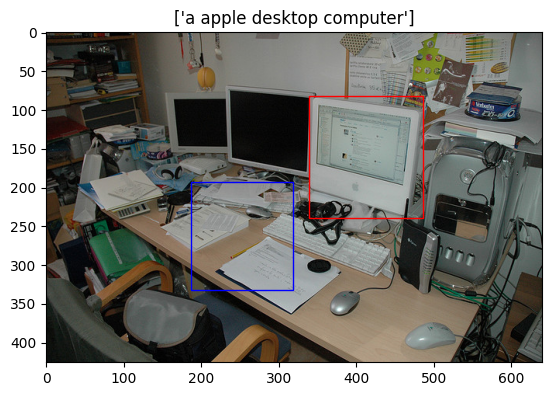

In [338]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# output_idx = 0

# Loading the image
img = image_test[0]

# Preparing the output
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

colors = ['r', 'b', 'g']

# Create a Rectangle patch
for bbox, color in zip([gt_bbox_test, pred_bbox], colors):
    bounding_box_coordinates = bbox.cpu()[0]
    top_left_x, top_left_y = bounding_box_coordinates[0], bounding_box_coordinates[1]
    width, height = bounding_box_coordinates[2]- top_left_x, bounding_box_coordinates[3] - top_left_y

    # Parameters: (x, y), width, height
    rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor=color, facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

ax.set_title(prompt_test)

In [88]:
gt_bbox_test, pred_bbox

(tensor([[374.3100,  65.0600, 510.3500, 267.0000]], device='cuda:0'),
 tensor([[113.8008,  54.9494, 410.0858, 333.5205]], device='cuda:0'))

### To compute average cosine similarity between embeddings

In [74]:
overall_outputs = []

for batch_idx, (images, gt_bounding_boxes, prompts) in enumerate(test_loader):
    print(f'-- Batch index: {batch_idx} --')

    # images_tensor = torch.stack([transform(image) for image in images]).to(device)
    
    indices = torch.tensor(list(range(len(images)))).to(device)
    prompts = [prompt_list[0] for prompt_list in prompts]

    with torch.no_grad():
        outputs = boundingbox_model(indices, images, prompts)

    # print(len(outputs))

    overall_outputs.append(outputs)

    if batch_idx == 0:
        break

-- Batch index: 0 --
<class 'PIL.Image.Image'>


In [44]:
overall_outputs[0][0], gt_bounding_boxes[0]

(tensor([184.0885, 138.4989, 400.0822, 378.5059], device='cuda:0'),
 [374.31, 65.06, 510.35, 267.0])

In [234]:
cos_sim_cpu = []
for out in overall_outputs:
    for cos_sim_val in out:
        cos_sim_cpu.append(cos_sim_val.item())
cos_sim_cpu = np.array(cos_sim_cpu)
np.nanmean(cos_sim_cpu)

0.2933678304222916

### To compute standard metrics

In [237]:
from torchvision.ops import boxes as box_ops

IoUs = []
cosine_similarities = []
  
for batch_idx, (images, gt_bounding_boxes, prompts) in enumerate(test_loader):
    print(f'-- Batch index: {batch_idx} --')

    prompts_tensor = [clip.tokenize(prompt_list) for prompt_list in prompts]
    
    indices = torch.tensor(list(range(len(images)))).to(device)
    outputs = baseline_model(indices, images, prompts)

    outputs_grouped_by_sample = []
    outputs_idx = 0
    prompts_idx = 0
    while True:
        if not prompts_idx < len(images):
            break

        outputs_grouped_by_sample.append(
            outputs[outputs_idx : outputs_idx + len(prompts[prompts_idx])]
        )

        outputs_idx += len(prompts[prompts_idx])
        prompts_idx += 1

    for output_bboxes, gt_bboxes in zip(outputs_grouped_by_sample, gt_bounding_boxes):
        """
        There is one output bounding box for each prompt given in input.
        Note that each prompt for a given input is actually a list of prompts,
        therefore it can contain an arbitrary number of promps. Hence, there is
        a bounding box for each one of them.
        """

        result_ious = iou_metric(output_bboxes, gt_bboxes)
        result_cosine_similarity = cosine_similarity_metric(output_bboxes, gt_bboxes)

        for iou in result_ious:
            IoUs.append(iou)

        for cs in result_cosine_similarity:
            cosine_similarities.append(cs)

-- Batch index: 0 --
-- Batch index: 1 --
-- Batch index: 2 --
-- Batch index: 3 --
-- Batch index: 4 --
-- Batch index: 5 --
-- Batch index: 6 --
-- Batch index: 7 --
-- Batch index: 8 --
-- Batch index: 9 --
-- Batch index: 10 --
-- Batch index: 11 --
-- Batch index: 12 --
-- Batch index: 13 --
-- Batch index: 14 --
-- Batch index: 15 --
-- Batch index: 16 --
-- Batch index: 17 --
-- Batch index: 18 --
-- Batch index: 19 --
-- Batch index: 20 --
-- Batch index: 21 --
-- Batch index: 22 --
-- Batch index: 23 --
-- Batch index: 24 --
-- Batch index: 25 --
-- Batch index: 26 --
-- Batch index: 27 --
-- Batch index: 28 --
-- Batch index: 29 --
-- Batch index: 30 --
-- Batch index: 31 --
-- Batch index: 32 --
-- Batch index: 33 --
-- Batch index: 34 --
-- Batch index: 35 --
-- Batch index: 36 --
-- Batch index: 37 --
-- Batch index: 38 --
-- Batch index: 39 --
-- Batch index: 40 --
-- Batch index: 41 --
-- Batch index: 42 --
-- Batch index: 43 --
-- Batch index: 44 --
-- Batch index: 45 -

In [238]:
IoUs_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in IoUs])
mIoU = np.nanmean(IoUs_to_cpu)

cosine_similarities_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in cosine_similarities])
m_cos_sim = np.nanmean(cosine_similarities_to_cpu)

print('--- Metrics ---')
print(f'Mean Intersection over Union (mIoU): {mIoU}')
print(f'Mean Cosine Similarity: {m_cos_sim}')

--- Metrics ---
Mean Intersection over Union (mIoU): 0.5163747769828632
Mean Cosine Similarity: 0.9557872927090548


TypeError: Image data of dtype object cannot be converted to float

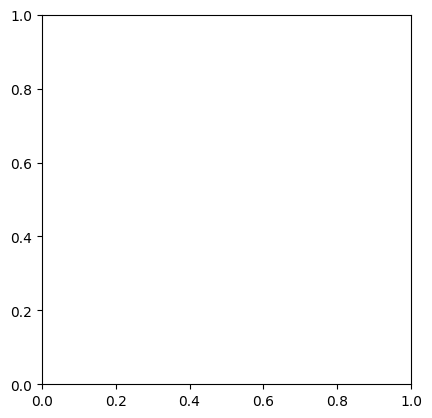

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

output_idx = 0

# Loading the image
img = images[output_idx]

# Preparing the output
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

colors = ['r', 'b', 'g']

# Create a Rectangle patch
for bbox, color in zip(outputs_grouped_by_sample[output_idx][1:2], colors):
    bounding_box_coordinates = bbox.cpu()
    top_left_x, top_left_y = bounding_box_coordinates[0], bounding_box_coordinates[1]
    width, height = bounding_box_coordinates[2]- top_left_x, bounding_box_coordinates[3] - top_left_y

    # Parameters: (x, y), width, height
    rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor=color, facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

ax.set_title(prompts[output_idx][1])

In [15]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

[<torch.cuda.device at 0x13d947f9060>, <torch.cuda.device at 0x13d947fb9a0>]